In [1]:
from SimPEG import (
    maps,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from SimPEG.electromagnetics.static import resistivity as DC, utils as DCutils
import discretize
import numpy as np
import time
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Create a mesh

number of cells = 27560


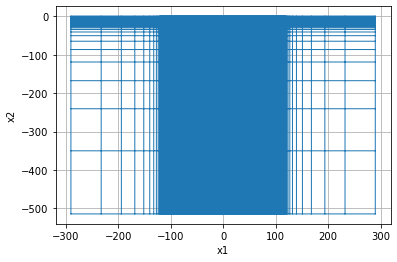

In [2]:
n_elec = 48 # number of electrodes
e_spacing = 5. # interelectrode spacing
n_between = 5. # how many cells between each electrode

csx = e_spacing / n_between 
csz = 0.25

# number of core cells 
ncx = n_elec * e_spacing * (1./csx)
ncz = 90

# number of padding cells 
npadx = 10
npadz = 16

# create mesh
hx = [(csx, npadx, -1.5), (csx, ncx), (csx, npadx, 1.5)]
hz = [(csz, npadz, -1.5), (csz, ncz)]
mesh = discretize.TensorMesh([hx, hz],x0="CN")

print("number of cells =", mesh.nC)

mesh.plotGrid();

# Create a survey


In [3]:
IO = DC.IO()
xmin, xmax = -117.5,117.5 # survey end points
zmin, zmax = 0, 0
endl = np.array([[xmin, zmin], [xmax, zmax]])
survey = DCutils.generate_dcip_survey(endl, "dipole-dipole", dim=mesh.dim, a=5, b=5, n=10)
survey = IO.from_ambn_locations_to_survey(
    survey.locations_a,
    survey.locations_b,
    survey.locations_m,
    survey.locations_n,
    survey_type='dipole-dipole',
    data_dc_type="volt",
)


/Users/teddiherringnew/anaconda/envs/simpeg14/lib/python3.7/site-packages/SimPEG/electromagnetics/static/resistivity/IODC.py:190: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


# Create a conductivity model

### Fluid conductivity

In [4]:
fl1 = 0.5 # background TDS (g/L)
fl2 = 150 # plume TDS (g/L)

fl_model = np.ones(mesh.nC) * fl1

# add conductive plume
x0, z0, r = 0, -15, 7.0
csph = (np.sqrt((mesh.gridCC[:, 0] - x0) ** 2.0
        + (mesh.gridCC[:, 1] - z0) ** 2.0)) < r
fl_model[csph] = np.ones_like(fl_model[csph]) * fl2


### Temperature

In [5]:
# load temperature curve from 1D conductive heat transport model, March profile
z = np.load('z_frozen.npy',encoding = 'latin1')
T = np.load('T_frozen.npy',encoding = 'latin1')

# interpolate onto mesh
T_mesh = np.interp(-mesh.vectorCCy,-z,T)
T2D = np.repeat(T_mesh,mesh.nCx)

# depth of frozen layer
fr_z = max(abs(z[np.where(T<0)]))


### Soil freezing characteristic curve (from Herring et al. 2019)

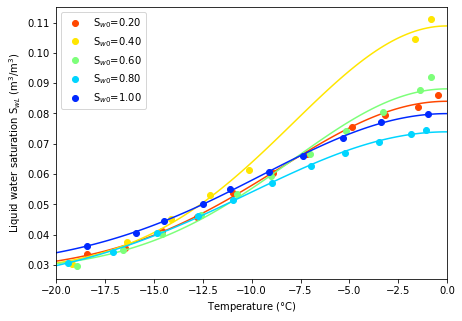

In [6]:

Swl_d = np.load('Swl_SFCC.npy',encoding = 'latin1',allow_pickle=True)
t_d = np.load('T_SFCC.npy',encoding = 'latin1',allow_pickle=True)

sws = np.array([0.2,0.4,0.6,0.8,1.0])

from scipy.optimize import curve_fit

def func_exp(T,w,Swres,Swsat):
    return Swres + (Swsat-Swres)*exp(-(T/w)**2)

target_func = func_exp
popt = []
xplt = linspace(-20,0,100)

for i in range(len(sws)):
    popt.append(curve_fit(target_func, t_d[i], Swl_d[i])[0])

fig = plt.figure(figsize=[7,5])
colors = plt.cm.jet(np.linspace(1,0,7))

for i in range(len(sws)):
    plt.plot(t_d[i],(Swl_d[i]),'o',color=colors[i+1],label='S$_{w0}$=%.2f'%sws[i]) 
    plt.plot(xplt,target_func(xplt, *popt[i]),color=colors[i+1])
    
plt.legend(numpoints=1)

plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Liquid water saturation S$_{wL}$ (m$^3$/m$^3$)')
plt.xlim([-20,0]);


### Petrophysical relationship (from Herring et al. 2019)

In [7]:
def ref2earth(T,a,por,m,n,Sw0,C0,d,popt=None):
    
    rho_f25 = (0.16*C0)**-1   

    rho_0 = rho_f25 * (d*(0-25)+1)**-1
        
    if T > 0:
        rho_f = rho_f25 * (d*(T-25)+1)**-1
        R_earth = a * por**-m * Sw0**-n *  rho_f

    else:
        Sw = func_exp(T, *popt)
        Sr = Sw/Sw0
        rho_f = (Sr*(rho_0))
        R_earth = a * por**-m * Sw**-n * rho_f

    return R_earth


### Putting it all together...

In [8]:
# fitting parameters from Herring et al. 2019
d = 0.0215
por = 0.40
Sw0 = 1.0
a = 0.363
m = 1.32 
n = 2.29

rho = []
for i in range(mesh.nC):
    rho = np.append(rho,ref2earth(T2D[i],a,por,m,n,Sw0,fl_model[i],d,popt[-1]))

sig = 1./rho.copy()    

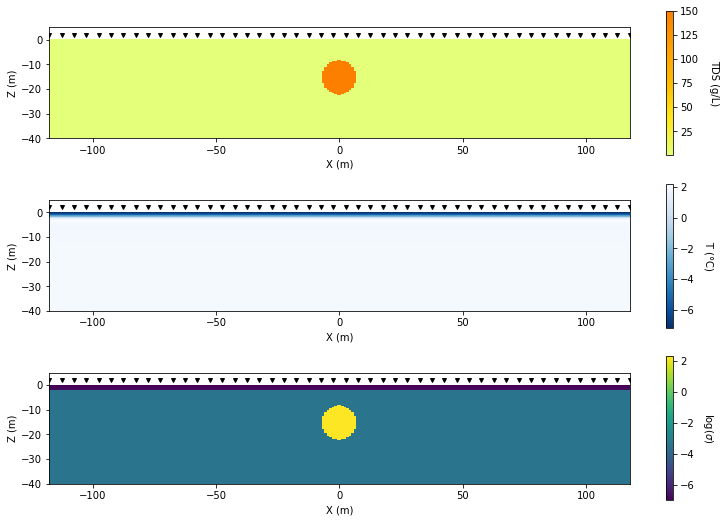

In [9]:
# plot model inputs and output
fig, ax = plt.subplots(3,1, figsize=[13,9])

dat = mesh.plotImage(fl_model,ax=ax[0],pcolorOpts={"cmap": "Wistia"})
cbar = colorbar(dat[0],ax=ax[0])
cbar.set_label('TDS (g/L)', rotation=270,labelpad=20)

dat = mesh.plotImage(T2D,ax=ax[1],pcolorOpts={"cmap": "Blues_r"})
cbar = colorbar(dat[0],ax=ax[1])
cbar.set_label(r'T ($\degree$C)', rotation=270,labelpad=20)

dat = mesh.plotImage(log(sig),ax=ax[2],pcolorOpts={"cmap": "viridis"})
cbar = colorbar(dat[0],ax=ax[2])
cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20)

for a in ax:
    a.set_ylim([-40,5])
    a.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
    a.set_xlabel('X (m)')
    a.set_ylabel('Z (m)')
    a.set_aspect(1)


# Simulate data

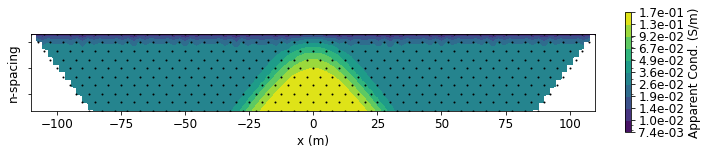

In [10]:
expmap = maps.ExpMap(mesh)
mapping = expmap 
simulation = DC.Simulation2DCellCentered(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver, bc_type="Neumann"
)

rel_err = 0.01
np.random.seed(1)
data = simulation.make_synthetic_data(log(1./rho), relative_error=rel_err, add_noise=True)
IO.plotPseudoSection(data=1./(data.dobs/IO.G), data_type="apparent_conductivity")

# Smooth inversion

In [11]:
from datetime import datetime
np.random.seed(2)

# simulation
sim = DC.Simulation2DCellCentered(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver, bc_type="Neumann",miniaturize=True)

# reference model 
m0 = np.ones(mapping.nP)*np.log(1./mean(data.dobs/IO.G))

# data misfit
dmisfit = data_misfit.L2DataMisfit(simulation=sim, data=data)

# regularization mapping
regmap = maps.IdentityMap(nP=mesh.nC)

# inversion components
reg = regularization.Tikhonov(mesh, mapping=regmap)
opt = optimization.InexactGaussNewton(maxIter=20)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
invProb.beta = 1.
target = directives.TargetMisfit()
saveIter = directives.SaveOutputEveryIteration()
saveModel = directives.SaveModelEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[saveIter,saveModel,target])

# run
start_time = time.time()
dtn_standard = datetime.now().strftime("%Y-%m-%d-%H-%M")
mopt_smooth = inv.run(m0)
dpred = sim.dpred(mopt_smooth)
mpe = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print('Mean percent data error = ',mpe)
print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2021-07-12-15-08.txt'
SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2021-07-12-15-08.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  5.57e+06  0.00e+00  5.57e+06    2.73e+05      0              
   1  1.00e+00  8.46e+05  3.94e-01  8.46e+05    4.16e+04      0              
   2  1.00e+00  1.69e+05  1.53e+01  1.69e+05    5.46e+03      0   Skip BFGS  
   3  1.00e+00  1.31e+05  2.25e+01  1.31e+05    3.67e+03      0              
 

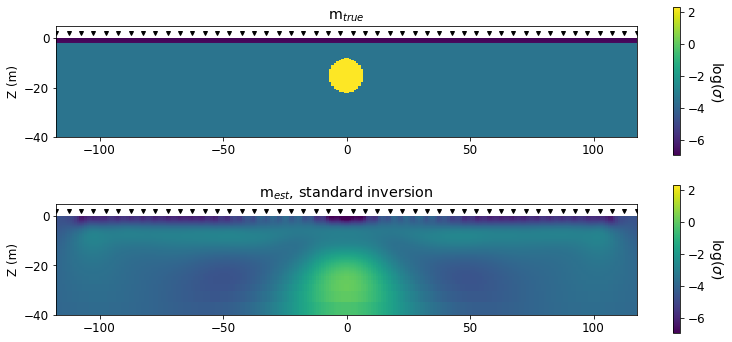

In [12]:
# estimated model 

fig, ax = plt.subplots(2,1, figsize=[13,6])

dat = mesh.plotImage(log(sig),ax=ax[0],clim=[min(log(sig)),max(log(sig))])
ax[0].set_title(r'm$_{true}$')

dat = mesh.plotImage(log(mapping*mopt_smooth),ax=ax[1],clim=[min(log(sig)),max(log(sig))])
ax[1].set_title(r'm$_{est}$, standard inversion')


for a in ax:
    cbar = colorbar(dat[0],ax=a)
    cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20,fontsize=14)
    a.set_aspect(1)
    a.set_ylim([-40,5])
    a.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
    a.set_xlabel('')
    a.set_ylabel('Z (m)')     

  


# Hybrid inversion

### Set up mapping function

In [13]:
import scipy.sparse as sp
from SimPEG.maps import BaseParametric 

class ParametricLayer(BaseParametric):
    """
        Parametric Layer Space

        .. code:: python

            m = [
                val_background,
                layer_z,
                func_coeffs 
            ]

        **Required**

        :param discretize.base.BaseMesh mesh: SimPEG Mesh, 2D or 3D

        **Optional**

        :param float slopeFact: arctan slope factor - divided by the minimum h
                                spacing to give the slope of the arctan
                                functions
        :param float slope: slope of the arctan function
        :param numpy.ndarray indActive: bool vector with

    """

    def __init__(self, mesh, **kwargs):
        super(ParametricLayer, self).__init__(mesh, **kwargs)

    @property
    def nP(self):
        return 4

    @property
    def shape(self):
        if self.indActive is not None:
            return (sum(self.indActive), self.nP)
        return (self.mesh.nC, self.nP)

    def mDict(self, m):
        return {
            "val_background": m[0],
            "layer_z": m[1],
            "func_coeffs": [m[2],m[3]]
        }

    def _atanLayer(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        layer_z = mDict["layer_z"]
        return self._atanfct(z - layer_z, self.slope)

    def f0(self, mDict, z):
        return mDict["func_coeffs"][0] +  mDict["func_coeffs"][1] * z
    
    def _transform(self, m):
        mDict = self.mDict(m)
        
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        
        return (
            self.f0(mDict, z) * self._atanLayer(mDict) + 
            mDict["val_background"] * (1 - self._atanLayer(mDict))
        )
    
    def _deriv_val_background(self, mDict):
        return np.ones_like(self.x) - self._atanLayer(mDict)
    
    def _deriv_layer_z(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        layer_z = mDict["layer_z"]
        return (
            (self.f0(mDict, z) - mDict["val_background"])*
            self._atanfctDeriv(z - layer_z, self.slope)
        )
    
    def _deriv_func_coeffs(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        return(
            np.vstack([
                self._atanLayer(mDict),
                z * self._atanLayer(mDict)
            ])
        )

    def deriv(self, m):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        mDict = self.mDict(m)
        return sp.csr_matrix(
            np.vstack(
                [
                    self._deriv_val_background(mDict),
                    self._deriv_layer_z(mDict),
                    self._deriv_func_coeffs(mDict)
                ]
            ).T
        )


Testing ParametricLayer(27560,4)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.700e+01     4.352e-03      nan
 1   1.00e-02    1.700e+00     3.863e-05      2.052
 2   1.00e-03    1.700e-01     3.820e-07      2.005
 3   1.00e-04    1.700e-02     3.815e-09      2.000
========================= PASS! =========================
Once upon a time, a happy little test passed.



(-120.0, 120.0)

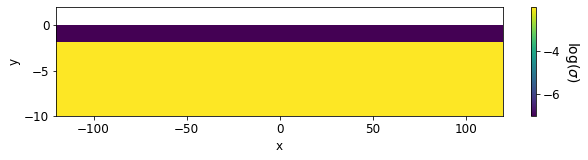

In [14]:
# test
parametric_layer = ParametricLayer(mesh,slopeFact=1e3)
m_background = -2
z_layer = -fr_z
m_coeffs = np.r_[-7,0]
m =  np.r_[m_background, z_layer, m_coeffs]

parametric_layer.test(m)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
cbar = plt.colorbar(mesh.plotImage(parametric_layer * m, ax=ax)[0], ax=ax)
cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20,fontsize=14)
ax.set_ylim([-10,2])
ax.set_xlim([-120,120])

### Inversion

In [20]:
from datetime import datetime

np.random.seed(0)

# mapping 

# parametric component
parametric_layer = ParametricLayer(mesh,slopeFact=1e3)
z_layer = -np.round(fr_z,2)
add_z_layer = maps.InjectActiveCells(mesh, np.r_[True, False, True, False], [z_layer,0], nC=4)
exp_map_parametric = maps.ExpMap(mesh)
parametric_map = (exp_map_parametric * parametric_layer * add_z_layer)

# smooth component
active_inds = mesh.gridCC[:, -1] < z_layer
n_active = active_inds.sum()
active_cells = maps.InjectActiveCells(mesh, active_inds , 0)
exp_map_smooth = maps.ExpMap(nP=int(n_active))
smooth_map = active_cells * exp_map_smooth 

# combine parameteric + smooth
wires = maps.Wires(("parametric", parametric_map.nP), ("smooth", int(n_active)))
sum_map = maps.SumMap([parametric_map * wires.parametric, smooth_map * wires.smooth])

# simulation 
sim_parametric = DC.Simulation2DCellCentered(
    mesh, survey=survey, sigmaMap=sum_map, solver=Solver, bc_type="Neumann",miniaturize=True)

# reference model 
rho_mean = mean(data.dobs/IO.G)
rho_max = max(data.dobs/IO.G)
m0_parametric = np.r_[np.log(1./rho_mean), np.log(1./rho_max)]
m0_smooth = np.log(1e-4)*np.ones(n_active)
m0 = np.hstack([m0_parametric, m0_smooth])

# data misfit
dmisfit = data_misfit.L2DataMisfit(simulation=sim_parametric, data=data)

# regularization mapping 
regmap = wires.smooth

# inversion components
reg = regularization.Tikhonov(mesh, mapping=regmap, indActive=active_inds)
opt = optimization.InexactGaussNewton(maxIter=20)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
invProb.beta = 1.
target = directives.TargetMisfit()
saveIter = directives.SaveOutputEveryIteration()
saveModel = directives.SaveModelEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[saveIter,saveModel,target])

# run
start_time = time.time()
dtn_hybrid = datetime.now().strftime("%Y-%m-%d-%H-%M")
mopt_hybrid = inv.run(m0) 

dpred = sim_parametric.dpred(mopt_hybrid)
mpe = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print('Mean percent data error = ',mpe)
print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2021-07-12-16-24.txt'
SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2021-07-12-16-24.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  5.63e+06  0.00e+00  5.63e+06    1.41e+07      0              
   1  1.00e+00  1.18e+06  0.00e+00  1.18e+06    1.94e+06      0              
   2  1.00e+00  8.44e+05  0.00e+00  8.44e+05    2.18e+05      0   Skip BFGS  
   3  1.00e+00  7.07e+05  0.00e+00  7.07e+05    1.96e+05      2   Skip BFGS  
 

### Plot results

Text(0.5, 0, 'X (m)')

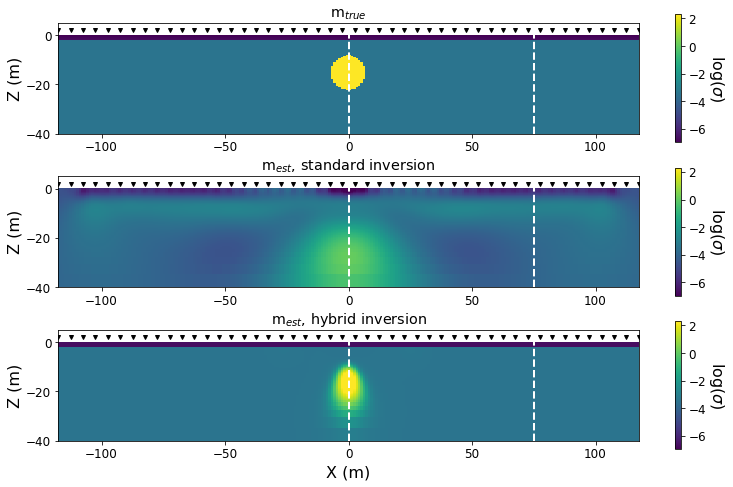

In [21]:
fs = 16
fig, ax = plt.subplots(3,1, figsize=[13,8])

dat = mesh.plotImage(log((sig)),ax=ax[0],clim=[min(log(sig)),max(log(sig))])
ax[0].set_title(r'm$_{true}$')

dat = mesh.plotImage(log(mapping*mopt_smooth),ax=ax[1],clim=[min(log(sig)),max(log(sig))])
ax[1].set_title(r'm$_{est}$, standard inversion')

dat = mesh.plotImage(log(sum_map*mopt_hybrid),ax=ax[2],clim=[min(log(sig)),max(log(sig))])
ax[2].set_title(r'm$_{est}$, hybrid inversion')

for a in ax:
    cbar = colorbar(dat[0],ax=a)
    cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20,fontsize=fs)
    a.set_aspect(1)
    a.set_ylim([-40,5])
    a.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1]+2,'kv',markersize=4)
    a.set_xlabel('')
    a.set_ylabel('Z (m)', fontsize=fs)  
    a.axvline(x=0,color='w',linestyle='dashed',linewidth=2)
    a.axvline(x=75,color='w',linestyle='dashed',linewidth=2)
ax[2].set_xlabel('X (m)', fontsize=fs)


# Compare standard and hybrid inversions

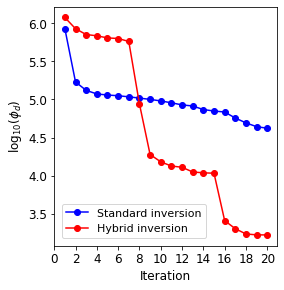

In [22]:
# convergence plots
fig, ax = plt.subplots(1,1, figsize=(4, 4.4))

iters_standard = np.loadtxt('InversionModel-'+dtn_standard+'.txt') # file created with inversion
iters_hybrid = np.loadtxt('InversionModel-'+dtn_hybrid+'.txt') # file created with inversion

ax.plot(linspace(1,20,20),log10(np.hstack([iters_standard.T[2]])),'bo-',label='Standard inversion')
ax.plot(linspace(1,20,20),log10(np.hstack([iters_hybrid.T[2]])),'ro-',label='Hybrid inversion')
ax.set_xticks(np.arange(0, 21, step=2));
ax.set_xlabel('Iteration')
ax.set_ylabel(r'log$_{10}$($\phi_d$)')
ax.legend(loc='lower left',bbox_to_anchor=(0.01, 0.01),fontsize=11)


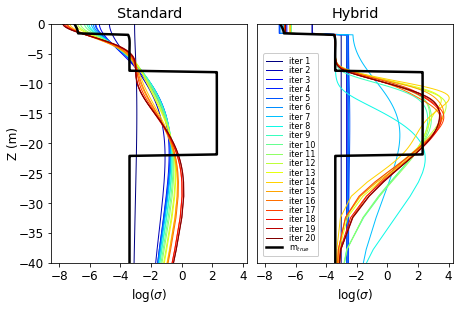

In [23]:
# plot iterations

# standard:

n_iter = len(iters_standard.T[0])

# load model at each iteration
m_i = []
for i in range(1, n_iter+1):
    if i  <10:
        m_i.append(np.load('00%d-InversionModel-'%i+dtn_standard+'.npy'))
    else:
        m_i.append(np.load('0%d-InversionModel-'%i+dtn_standard+'.npy'))
m_i = np.array(m_i)

# plot
colors = plt.cm.jet(np.linspace(0,1,n_iter))
xsl = int(mesh.nCx/2)

fig, ax = plt.subplots(1,2, figsize=[7.2,4.4])

import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
ax[0] = plt.subplot(gs1[0])
ax[1] = plt.subplot(gs1[1])

for i in range(0,n_iter):
    ax[0].plot((np.reshape(log(mapping * m_i[i]),[mesh.nCx,mesh.nCy],order='F'))[xsl],
             (mesh.vectorCCy),'-',color=colors[i],label='iter %.0f'%(i+1),linewidth=1)

# hybrid:

n_iter = len(iters_hybrid.T[0])

# load model at each iteration
m_i = []
for i in range(1, n_iter+1):
    if i  <10:
        m_i.append(np.load('00%d-InversionModel-'%i+dtn_hybrid+'.npy'))
    else:
        m_i.append(np.load('0%d-InversionModel-'%i+dtn_hybrid+'.npy'))
m_i = np.array(m_i)

# plot
colors = plt.cm.jet(np.linspace(0,1,n_iter))
xsl = int(mesh.nCx/2)

for i in range(0,n_iter):
    ax[1].plot((np.reshape(log(sum_map * m_i[i]),[mesh.nCx,mesh.nCy],order='F'))[xsl],
             (mesh.vectorCCy),'-',color=colors[i],label='iter %.0f'%(i+1),linewidth=1)

for a in ax:
    a.plot(np.reshape(log(sig),[mesh.nCx,mesh.nCy],order='F')[xsl],
             (mesh.vectorCCy),'k-',label=r'm$_{true}$',linewidth=2.5)
    a.set_ylim([-40,0])
    a.set_xlabel(r'log($\sigma$)')
    if a==ax[0]:
        a.set_ylabel("Z (m)",labelpad=-1)
    a.set_xlim([-8.5,4.3])
    a.set_xticks(np.arange(-8, 6, step=2));
ax[0].set_title('Standard')
ax[1].set_title('Hybrid')
ax[1].tick_params(axis='y',left=False)
ax[1].legend(loc='lower left',bbox_to_anchor=(0.01, 0.01),
             labelspacing=0.04,fontsize=8,framealpha=1)

frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([]);


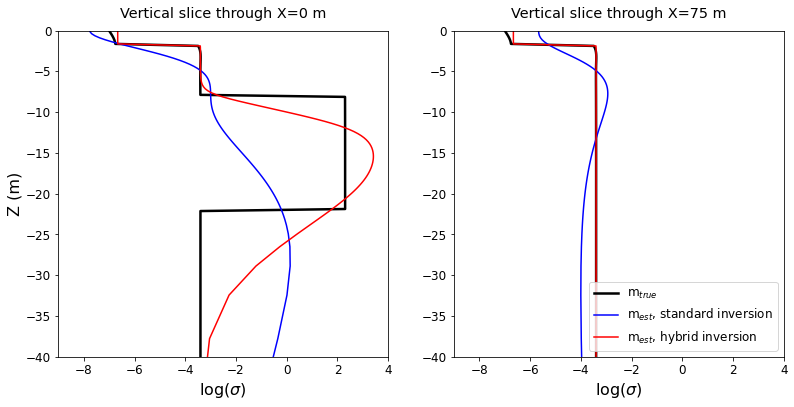

In [24]:
# plot slices

fig, ax = plt.subplots(1,2, figsize=[13,6])

# at x=0m
xsl = int(mesh.nCx/2)
ax[0].plot(np.reshape(log(sig),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'k-',label=r'm$_{true}$',linewidth=2.5)

ax[0].plot(np.reshape(log(exp(mopt_smooth)),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'b',label=r'm$_{est}$, standard inversion',linewidth=1.5)

ax[0].plot(np.reshape(log(sum_map * mopt_hybrid),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'r-',label=r'm$_{est}$, hybrid inversion',linewidth=1.5)

ax[0].set_title('Vertical slice through X=0 m',y=1.02);    

# at x=75m 
xsl = int(mesh.nCx/2)+74
ax[1].plot(np.reshape(log(1./rho),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'k-',label=r'm$_{true}$',linewidth=2.5)

ax[1].plot(np.reshape(log(exp(mopt_smooth)),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'b',label=r'm$_{est}$, standard inversion',linewidth=1.5)

ax[1].plot(np.reshape(log(sum_map * mopt_hybrid),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'r-',label=r'm$_{est}$, hybrid inversion',linewidth=1.5)

ax[1].set_title('Vertical slice through X=75 m',y=1.02);

for a in ax:
    a.set_ylim([-40,0])
    a.set_xlim([-9,4])
    a.set_xlabel(r'log($\sigma$)',fontsize=fs)
ax[0].set_ylabel('Z (m)',fontsize=fs)
  
plt.legend();
